<a href="https://colab.research.google.com/github/Jmerinom22/Codigo-Proyecto/blob/main/Modelo_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base de datos **(La Paz)**

In [1]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo, sep=';')  # Quien use este codigo asegúrate de usar el separador correcto

num_observaciones, num_variables = df.shape
print(f"Número de observaciones (filas): {num_observaciones}")
print(f"Número de variables (columnas): {num_variables}")

print("\n Lista de variables:")
print(df.columns.tolist())

Saving base_datos_solar_lapaz_2025 (1).csv to base_datos_solar_lapaz_2025 (1).csv
Número de observaciones (filas): 2880
Número de variables (columnas): 6

 Lista de variables:
['time', 'shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'energia_solar_kWh']


# Aproximaciones

## Modelo MLP (Perceptrón Multicapa)

Un MLP:

- Aprende relaciones no lineales
- Se entrena más rápido que GRU o LSTM
- Se usa en muchos papers como baseline (modelo base)
- Es fácil de interpretar y comparar



### generar secuencias para GRU

Vamos a usar una ventana de 24 horas (1 día) como entrada para predecir la energía de la siguiente hora.

In [2]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(3).mean()

df = df.dropna()

X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])
y = df['energia_solar_kWh']

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

variables_usar = ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m',
                  'hora', 'dia_del_año', 'energia_solar_kWh']

datos = df[variables_usar].copy()

scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

def crear_secuencias(datos, ventana=24):
    X, y = [], []
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, :])
        y.append(datos[i, -1])
    return np.array(X), np.array(y)

X_seq, y_seq = crear_secuencias(datos_scaled, ventana=24)

print(" Formato de X (samples, pasos, variables):", X_seq.shape)
print(" Formato de y:", y_seq.shape)

 Formato de X (samples, pasos, variables): (2832, 24, 6)
 Formato de y: (2832,)


### Separar datos en entrenamiento y prueba (para GRU)

- 80% para entrenamiento
- 20% más reciente para prueba

In [5]:
n_muestras = X_seq.shape[0]
n_train = int(n_muestras * 0.8)

X_train, X_test = X_seq[:n_train], X_seq[n_train:]
y_train, y_test = y_seq[:n_train], y_seq[n_train:]

print(" X_train:", X_train.shape)
print(" X_test:", X_test.shape)
print(" y_train:", y_train.shape)
print(" y_test:", y_test.shape)

 X_train: (2265, 24, 6)
 X_test: (567, 24, 6)
 y_train: (2265,)
 y_test: (567,)


### Aplanar las secuencias

In [7]:
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

print(" Formato de X_train para MLP:", X_train_mlp.shape)
print(" Formato de X_test para MLP:", X_test_mlp.shape)

 Formato de X_train para MLP: (2265, 144)
 Formato de X_test para MLP: (567, 144)


### Construir y entrenar el modelo MLP

Vamos a usar una red neuronal simple:

- 2 capas ocultas con 128 y 64 neuronas
- Activación relu
- Capa de salida con 1 neurona (predicción de energía solar)
- Función de pérdida `mse`

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

modelo_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(144,)),
    Dense(64, activation='relu'),
    Dense(1)
])

modelo_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

historial_mlp = modelo_mlp.fit(
    X_train_mlp, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_mlp, y_test),
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0644 - mae: 0.1615 - val_loss: 0.0089 - val_mae: 0.0687
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0424 - val_loss: 0.0079 - val_mae: 0.0625
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mae: 0.0316 - val_loss: 0.0056 - val_mae: 0.0523
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0298 - val_loss: 0.0072 - val_mae: 0.0632
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0334 - val_loss: 0.0057 - val_mae: 0.0502
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0073 - val_mae: 0.0587
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0049 - val_mae: 0.0454
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mae: 0.0270 - val_loss: 0.0046 - val_mae: 0.0454
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0275 - va

El modelo MLP se entrenó bien y la función de pérdida (val_loss) terminó en 0.0034, lo que ya sugiere un buen ajuste.

### Evaluar el MLP (RMSE, R²)

In [9]:
y_pred_mlp_scaled = modelo_mlp.predict(X_test_mlp)

y_test_full_mlp = np.zeros((len(y_test), 6))
y_test_full_mlp[:, -1] = y_test

y_pred_full_mlp = np.zeros((len(y_pred_mlp_scaled), 6))
y_pred_full_mlp[:, -1] = y_pred_mlp_scaled[:, 0]

y_test_inv_mlp = scaler.inverse_transform(y_test_full_mlp)[:, -1]
y_pred_inv_mlp = scaler.inverse_transform(y_pred_full_mlp)[:, -1]

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

rmse_mlp = np.sqrt(mean_squared_error(y_test_inv_mlp, y_pred_inv_mlp))
r2_mlp = r2_score(y_test_inv_mlp, y_pred_inv_mlp)

print(f" RMSE (MLP): {rmse_mlp:.4f}")
print(f" R² (MLP): {r2_mlp:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 RMSE (MLP): 0.0157
 R² (MLP): 0.9630


| Métrica | Valor  | Comentario                                  |
| ------- | ------ | ------------------------------------------- |
|  RMSE  | 0.0157 | Error bajo, pero mayor que GRU/XGBoost      |
|  R²    | 0.9630 | Explica el **96.3%** de la energía generada |


- El MLP funciona bien, pero no tan bien como:
  - GRU (R² = 96.3%)
  - XGBoost con series (R² = 97.57%)
- Aún así, es un modelo rápido, simple y estable, útil como base.

In [11]:
from sklearn.metrics import mean_absolute_error

mae_mlp = mean_absolute_error(y_test_inv_mlp, y_pred_inv_mlp)

mape_mlp = np.mean(np.abs((y_test_inv_mlp - y_pred_inv_mlp) / np.where(y_test_inv_mlp == 0, np.nan, y_test_inv_mlp))) * 100
mape_mlp = np.nan_to_num(mape_mlp)

print(f" MAE (MLP): {mae_mlp:.4f}")

 MAE (MLP): 0.0091


In [12]:
mask = y_test_inv_mlp > 0.01
mape_filtrado = np.mean(np.abs((y_test_inv_mlp[mask] - y_pred_inv_mlp[mask]) / y_test_inv_mlp[mask])) * 100

print(f" MAPE filtrado (MLP): {mape_filtrado:.2f}%")

 MAPE filtrado (MLP): 17.80%


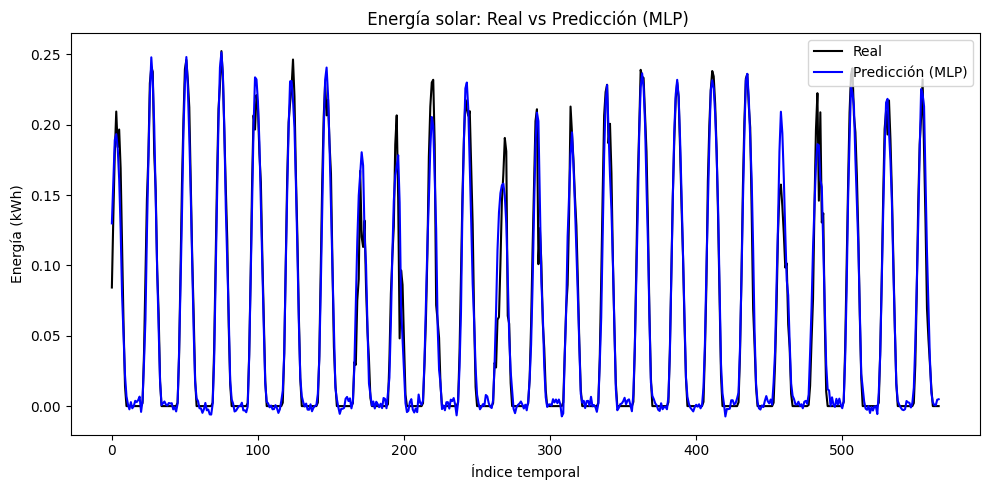

In [13]:
# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv_mlp, label='Real', color='black')
plt.plot(y_pred_inv_mlp, label='Predicción (MLP)', color='blue')
plt.title(" Energía solar: Real vs Predicción (MLP)")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

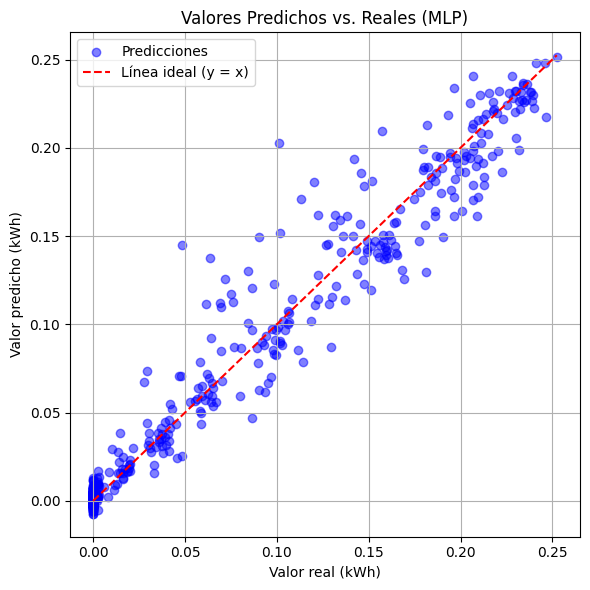

In [14]:
import matplotlib.pyplot as plt

y_true_flat_mlp = y_test_inv_mlp.ravel()
y_pred_flat_mlp = y_pred_inv_mlp.ravel()

# Gráfica de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat_mlp, y_pred_flat_mlp, color='blue', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_flat_mlp)], [0, max(y_true_flat_mlp)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (MLP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
